<a href="https://colab.research.google.com/github/danzerca/aim4/blob/main/Advanced_Retrieval_with_LangChain_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

In [ ]:
# !pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [ ]:
# !pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [ ]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [117]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

Cohere API Key:··········


## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [ ]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [17]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [18]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2024, 9, 28, 13, 46, 54, 855779)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [19]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [20]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [21]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [22]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [44]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [147]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Opinions on John Wick seem to vary. Some people really enjoyed it, while others did not.'

In [148]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I'm sorry, there are no reviews with a rating of 10 in the provided context."

In [149]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character is a skilled assassin seeking vengeance for the death of his beloved dog, given to him by his deceased wife. The movie is known for its intense action sequences and choreography.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [50]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [115]:
bm25_retriever_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [150]:
bm25_retriever_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Overall, opinions on John Wick seem to vary. Some people really enjoyed the action and style of the movie, while others found it lacking in substance and plot. So, it's safe to say that not everyone liked John Wick."

In [151]:
bm25_retriever_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I'm sorry, there are no reviews with a rating of 10 in the provided context."

In [152]:
bm25_retriever_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character, portrayed by Keanu Reeves, is a retired hitman seeking vengeance for the death of his beloved dog, which was a final gift from his deceased wife. The movie showcases intense action sequences and a compelling emotional narrative.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [118]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [119]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [153]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the positive reviews provided.'

In [154]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3". Here is the URL to that review: /review/rw4854296/?ref_=tt_urv'

In [155]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, after resolving his issues with the Russian mafia, John Wick returns home but is visited by mobster Santino D'Antonio who asks him to kill his sister so that he can take her place in the criminal organizations. When John completes the task, Santino puts a contract on him, attracting professional killers from all over. Ultimately, Wick promises to kill Santino who is no longer protected by his marker."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [120]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [121]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [156]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems like people generally liked John Wick. The action sequences, Keanu Reeves' performance, and the overall entertainment value of the movie received positive feedback."

In [157]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. Here is the URL to that review: '/review/rw4854296/?ref_=tt_urv'"

In [158]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, a retired assassin named John Wick seeks revenge after someone kills his dog and steals his car. This sets off a chain of events that leads to a lot of carnage as John Wick takes on various adversaries in different locations.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [122]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [123]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

<ipython-input-123-4887b10d4438>:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the langchain-qdrant package and should be used instead. To use it run `pip install -U langchain-qdrant` and import as `from langchain_qdrant import Qdrant`.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [124]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [125]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [126]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [159]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"People's opinions on John Wick seem to vary. Some really enjoy the series and find it consistent and well-received, while others have strong negative opinions about specific installments like John Wick 4."

In [160]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3". The URL to that review is \'/review/rw4854296/?ref_=tt_urv\'.'

In [161]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, Keanu Reeves plays the character of John Wick, a retired assassin who comes out of retirement after someone kills his dog and steals his car. He is forced back into the world of assassins to pay off an old debt and ends up traveling to Italy, Canada, and Manhattan to take down numerous assassins.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [127]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [128]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [162]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick based on the reviews provided. The action sequences, Keanu Reeves' performance, and the overall style of the movie were praised by many reviewers."

In [163]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. Here is the URL to that review:\n- URL: '/review/rw4854296/?ref_=tt_urv'"

In [164]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, an ex-hitman comes out of retirement to seek vengeance on the gangsters who killed his dog and took everything from him. The story is filled with violent action, shootouts, and breathtaking fights as John Wick unleashes a maelstrom of destruction against those who are after him. The movie is known for its stylish action sequences and intense revenge plot.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

In [ ]:
!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [134]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [135]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [136]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [137]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [138]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [166]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, it seems that people generally liked John Wick. The reviews mention positive aspects such as the action sequences, the coolness of the main character, and the overall entertainment value of the movie.'

In [167]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3." The URL to that review is \'/review/rw4854296/?ref_=tt_urv\'.'

In [168]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the protagonist seeks revenge on the people who took something he loved from him. This leads to a series of events involving action, stylish stunts, kinetic chaos, and a relatable hero.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [ ]:
!pip uninstall -y langchain langchain-community langchain-core langchain-experimental langchain-openai langchain-qdrant qdrant-client ragas rank-bm25 langchain_cohere ragas

In [2]:

!pip install -q langchain==0.2.16 langchain-community==0.2.16 langchain-core==0.2.38 langchain-experimental==0.0.65 langchain-openai==0.1.23 langchain-qdrant==0.1.4 qdrant-client==1.11.3 ragas==0.1.20 rank-bm25==0.2.2 langchain_cohere

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 937.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [3]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

Enter your OpenAI API Key:··········


In [5]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - Advanced Retrieval - {uuid4().hex[0:8]}"

In [8]:
### 1. Create a "golden dataset"
from langchain_community.document_loaders import CSVLoader

test_documents = CSVLoader("john_wick_1.csv").load()


In [9]:
from ragas.testset.generator import TestsetGenerator
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas.testset.evolutions import simple, reasoning, multi_context

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4-0125-preview", tags=["base_llm"])
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

In [11]:
result = generator.generate_with_langchain_docs(test_documents, 20, distributions, with_debugging_logs=False)

embedding nodes:   0%|          | 0/50 [00:00<?, ?it/s]

Generating:   0%|          | 0/20 [00:00<?, ?it/s]

In [58]:
from datasets import Dataset

In [57]:
dataset = Dataset.from_pandas(result.to_pandas())

In [35]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
)

In [112]:
def answer_question(chain, dataset):
    answers = []
    contexts = []
    questions = dataset.to_pandas()["question"].values.tolist()
    ground_truths = dataset.to_pandas()["ground_truth"].values.tolist()

    for question in questions:
        answer = chain.invoke({"question" : question})
        answers.append(answer["response"].content)
        contexts.append([context.page_content for context in answer["context"]])
    return Dataset.from_dict({
        "question" : questions,
        "answer" : answers,
        "contexts" : contexts,
        "ground_truth" : ground_truths,
    })

In [113]:
# 2.1 Naive Retrieval
# context_precision: Measures how relevant the retrieved documents are, which is crucial for naive retrieval as it doesn't use sophisticated ranking.
# context_recall: Assesses if the retriever captures all relevant information, important for naive methods that might miss nuanced connections.
# answer_relevancy: Evaluates if the simple retrieval leads to relevant answers despite its basic approach.

naive_metrics = [
    context_precision,
    context_recall,
    answer_relevancy
]

naive_dataset = answer_question(naive_retrieval_chain, dataset)

naive_results = evaluate(naive_dataset, naive_metrics)
naive_results

Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

{'context_precision': 0.5307, 'context_recall': 0.7018, 'answer_relevancy': 0.9808}

In [129]:
# 2.2 Best-Matching 25 (BM25)
# context_precision: Reflects BM25's ability to rank relevant documents higher.
# context_recall: Shows if BM25 captures a wide range of relevant documents.
# answer_relevancy: Indicates if BM25's term-frequency based approach leads to relevant answers.

bm25_metrics = [
    context_precision,
    context_recall,
    answer_relevancy
]

bm25_dataset = answer_question(bm25_retriever_chain, dataset)

bm25_results = evaluate(bm25_dataset, bm25_metrics)
bm25_results

Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

{'context_precision': 0.5570, 'context_recall': 0.7018, 'answer_relevancy': 0.9257}

In [130]:
# 2.3 Multi-Query Retrieval
# faithfulness: Assesses if multiple queries lead to consistent and accurate information retrieval.
# answer_relevancy: Evaluates if diverse queries result in more relevant answers.
# context_recall: Measures if multiple queries capture a broader range of relevant information.
# context_precision: Indicates if the multiple queries improve the relevance of retrieved documents.
# answer_correctness: Assesses if multiple perspectives lead to more accurate answers.

multi_query_metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness
]

multi_query_dataset = answer_question(multi_query_retrieval_chain, dataset)

multi_query_results = evaluate(multi_query_dataset, multi_query_metrics)
multi_query_results

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

{'faithfulness': 0.8762, 'answer_relevancy': 0.9743, 'context_recall': 0.9561, 'context_precision': 0.7268, 'answer_correctness': 0.6509}

In [131]:
# 2.4 Parent-Document Retrieval
# faithfulness: Evaluates if the parent-child structure maintains context accuracy.
# answer_relevancy: Assesses if the hierarchical approach leads to more relevant answers.
# context_recall: Measures if both parent and child documents are effectively retrieved.
# context_precision: Indicates if the parent-child relationship improves relevance.
# answer_correctness: Evaluates if the hierarchical structure leads to more accurate answers.

parent_document_metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness
]

parent_document_dataset = answer_question(parent_document_retrieval_chain, dataset)

parent_document_results = evaluate(parent_document_dataset, parent_document_metrics)
parent_document_results

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

{'faithfulness': 0.8578, 'answer_relevancy': 0.9750, 'context_recall': 0.5965, 'context_precision': 0.7544, 'answer_correctness': 0.5840}

In [ ]:
# 2.5 Contextual Compression (Rerank)
# faithfulness: Assesses if reranking maintains or improves context accuracy.
# answer_relevancy: Evaluates if reranking leads to more relevant answers.
# context_recall: Measures if reranking still captures all relevant information.
# context_precision: Directly reflects the improvement in relevance due to reranking.
# answer_correctness: Assesses if reranking leads to more accurate answers.

compression_metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness
]

compression_dataset = answer_question(contextual_compression_retrieval_chain, dataset)

compression_results = evaluate(compression_dataset, compression_metrics)
compression_results

In [ ]:
# 2.6 Ensemble Retrieval
# faithfulness: Evaluates if combining methods maintains context accuracy.
# answer_relevancy: Assesses if the ensemble approach leads to more relevant answers.
# context_recall: Measures if the ensemble captures a wider range of relevant information.
# context_precision: Indicates if the ensemble improves overall relevance.
# answer_correctness: Evaluates if combining methods leads to more accurate answers.

ensemble_metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness
]

ensemble_dataset = answer_question(ensemble_retrieval_chain, dataset)

ensemble_results = evaluate(ensemble_dataset, ensemble_metrics)
ensemble_results

In [139]:
# 2.7 Semantic Chunking
# faithfulness: Evaluates if combining methods maintains context accuracy.
# answer_relevancy: Assesses if the ensemble approach leads to more relevant answers.
# context_recall: Measures if the ensemble captures a wider range of relevant information.
# context_precision: Indicates if the ensemble improves overall relevance.
# answer_correctness: Evaluates if combining methods leads to more accurate answers.

semantic_metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness
]

semantic_dataset = answer_question(semantic_retrieval_chain, dataset)

semantic_results = evaluate(semantic_dataset, semantic_metrics)
semantic_results

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

{'faithfulness': 0.9159, 'answer_relevancy': 0.9746, 'context_recall': 0.9825, 'context_precision': 0.6909, 'answer_correctness': 0.6820}

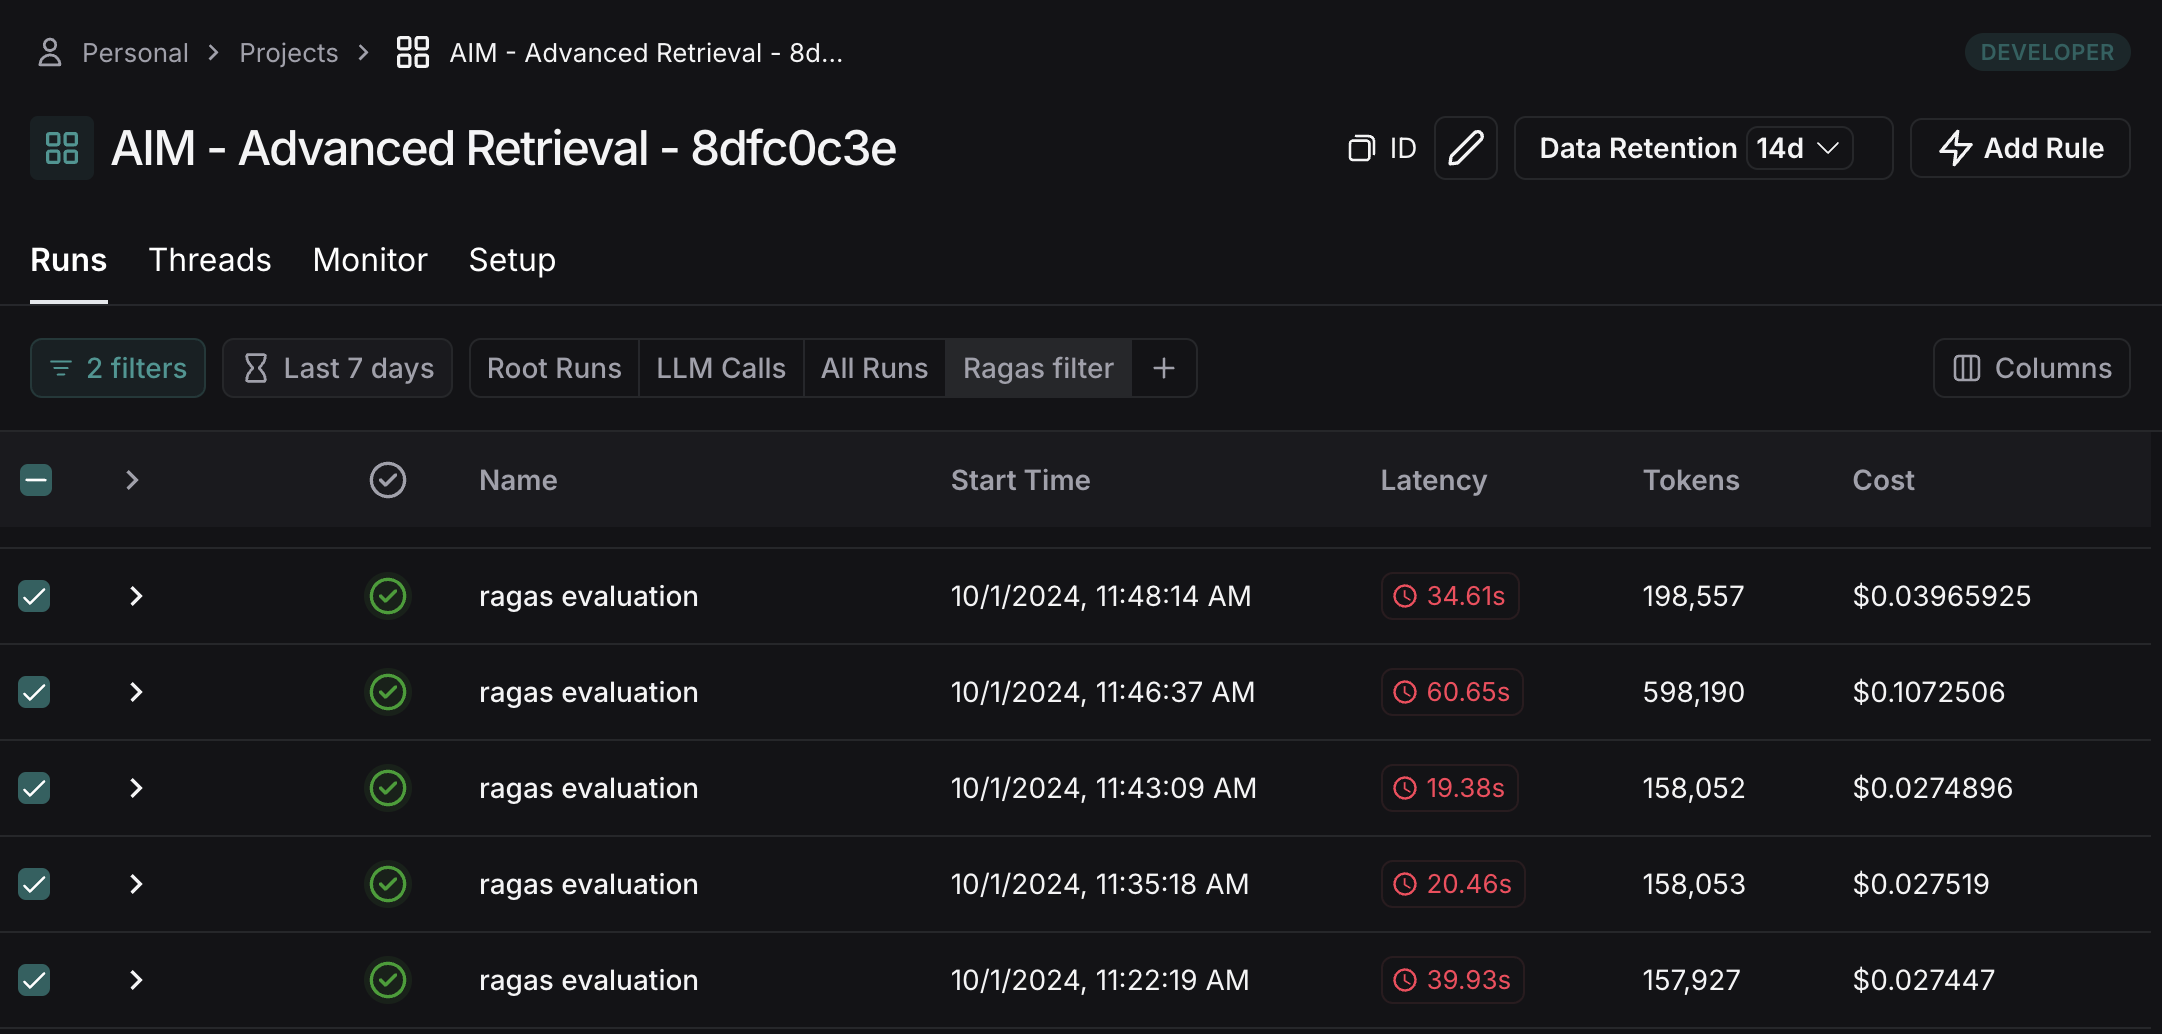

The above results correspond to the following runs:

Time - Retriever - Latency - Tokens - Cost

11:48AM - Semantic Chunking - 34.61s - 198,557 - $0.03965925

11:46AM - Parent Document - 60.65s - 598,190 - $0.1072506

11:43AM - MultiQuery - 19.38s - 158,052 - $0.0274896

11:35AM - BFM25 - 20.46s - 158,053 - $0.027519

11:22AM - Naive - 39.93s - 157,927 - $0.027447



In [146]:
import pandas as pd
df_naive = pd.DataFrame(list(naive_results.items()), columns=['Metric', 'Naive'])
df_bfm25 = pd.DataFrame(list(bm25_results.items()), columns=['Metric', 'BFM25'])
df_multi_query = pd.DataFrame(list(multi_query_results.items()), columns=['Metric', 'MultiQuery'])
df_parent_document = pd.DataFrame(list(parent_document_results .items()), columns=['Metric', 'ParentDocument'])
# df_semantic = pd.DataFrame(list(semantic_results.items()), columns=['Metric', 'Semantic'])

df_merged = pd.merge(df_naive, df_bfm25, on='Metric')
df_merged = pd.merge(df_merged, df_multi_query, on='Metric')
df_merged = pd.merge(df_merged, df_parent_document, on='Metric')
# df_merged = pd.merge(df_merged, df_semantic, on='Metric')

df_merged


,Metric,Naive,BFM25,MultiQuery,ParentDocument
0,context_precision,0.530702,0.557018,0.72681,0.754386
1,context_recall,0.701754,0.701754,0.95614,0.596491
2,answer_relevancy,0.980817,0.925741,0.97431,0.974951


In [145]:
df_multi_query = pd.DataFrame(list(multi_query_results.items()), columns=['Metric', 'MultiQuery'])
df_parent_document = pd.DataFrame(list(parent_document_results .items()), columns=['Metric', 'ParentDocument'])
# df_semantic = pd.DataFrame(list(semantic_results.items()), columns=['Metric', 'Semantic'])

df_merged = pd.merge(df_multi_query, df_parent_document, on='Metric')
# df_merged = pd.merge(df_merged, df_semantic, on='Metric')

df_merged

,Metric,MultiQuery,ParentDocument
0,faithfulness,0.876190,0.857769
1,answer_relevancy,0.974310,0.974951
2,context_recall,0.956140,0.596491
3,context_precision,0.726810,0.754386
4,answer_correctness,0.650923,0.583996


Looking at the results of the chains with various retrievers, the Multi-Query Retriever has high results across the board. It has high context recall (0.956140) and answer relevancy (0.974310). Additionally, it is one of the cheaper (158,052 tokens for $0.0274896), faster (avg 19.38s) retrievers. The Multi-Query Retriever is well-suited for the John Wick dataset because movie reviews often contain diverse perspectives and complex information. By generating multiple queries from a single user question, it can capture different aspects of the movies, such as plot, action sequences, character development, and overall reception. This approach is particularly effective for handling nuanced or multi-faceted questions about the films, as it increases the likelihood of retrieving relevant information from various reviews that may use different terminology or focus on different aspects of the movies. Additionally, the Multi-Query Retriever can help overcome potential vocabulary mismatches between user queries and the specific language used in reviews, improving the overall retrieval performance.